In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import loadmat  # this is the module that loads mat-files

plt.rcParams['figure.figsize'] = [10, 7]
%matplotlib inline

In [90]:
def read_file_into_df(f_name):
    """ 
    Reads data from one .mat file into a DataFrame.
    Expects data files to be in the root/data_raw folder. 
    """
    
    mat = loadmat(f"data_raw/{f_name}")
    df = pd.DataFrame(mat['data'])
    df.columns = ['time_sec', 'time_microsec', 'signal_horizontal', 'signal_vertical', 'class']
    
    df['time_full'] = df['time_sec'] + (df['time_microsec'] / 1_000_000)
    #df['time_full_str'] = df['time_full_str'].astype(str)
    #df = df[['time_sec','time_microsec','time_full','signal_horizontal','signal_vertical','class']]
    
    return df

def read_all_files():
    """
    Reads all data files into DataFrames and puts them into a 2D dictionary.
    To access a file, the first key is the participant (1 - 8), second key is the experiment (0, 1).
    Example: to get the data from the first experiment of participant 5, use dict[5][0]
    """
    
    d = {}
    
    for participant in range(1, 9):
        d[participant] = {}
        
        for experiment in range(0, 2):
            d[participant][experiment] = read_file_into_df(f"participant{participant}_{experiment}.mat")       
    return d

def all_datasets_read_correctly(d):
    """ Checks if all datasets were read correctly (all datasets contain all classes). """
    
    for p in range(1, 9): # participant
        p_dict = d[p]
    
        for e in range(0, 2): # experiment
            e_dict = p_dict[e]
            labels = e_dict['class'].unique()
            
            for c in range(1, 9): # class label
                if c not in labels:
                    print(f"Class {c} not found in participant {p} experiment {e}!")
                    return
    print("Looks good! All datasets contain all classes.")

In [91]:
# Reads all datasets into 2D dict.
# First key is participant nr (1 - 8), second is experiment nr (0, 1)
dataset_dict = read_all_files()
#participant5_experiment0_data = dataset_dict[5][0]

all_datasets_read_correctly(dataset_dict)

Looks good! All datasets contain all classes.


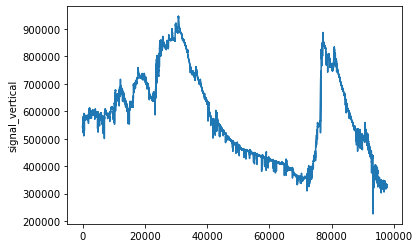

In [92]:
plt.plot(df['signal_vertical'])
plt.ylabel('signal_vertical')
plt.show()

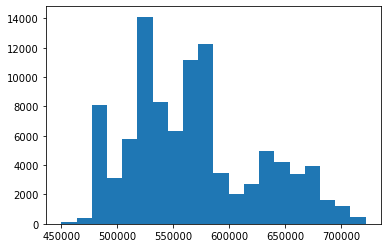

In [93]:
plt.hist(df.signal_horizontal, bins=20)
plt.show()